# Forecasting using window based regression

All aeon forecasters work by fitting on a series then making a single prediction 
about a future value. How they make the prediction defines the algorithm.

One common approach is to convert the forecasting problem into a regression problem 
through the application of a sliding window. A fixed interval is slid across the 
series to form a collection of time series. This is encapsulated in the 
`RegressionForecaster` in the `aeon.forecasting` module. We break down what is 
happening inside the forecaster before showing how to use `RegressionForecaster` to 
achieve the same effect.

<img src="img/window.png" width="600" alt="windowing">


In terms of regression, each window forms a set of explanatory variables the 
value after the window is the response. Together a window and response form a training 
case. Formatted like this, we can apply an `sklearn` tabular regressor or an `aeon` 
time series regressor. 

The response variable is the value directly after the window (if the horizon is 1). 
This is of course unknown for the last window, so we will assume that is the case we 
want to use to make a forecast.  

In [36]:
from numpy.lib.stride_tricks import sliding_window_view

from aeon.datasets import load_airline

y = load_airline()
X_train = sliding_window_view(y, window_shape=100)
X_train.shape

(45, 100)

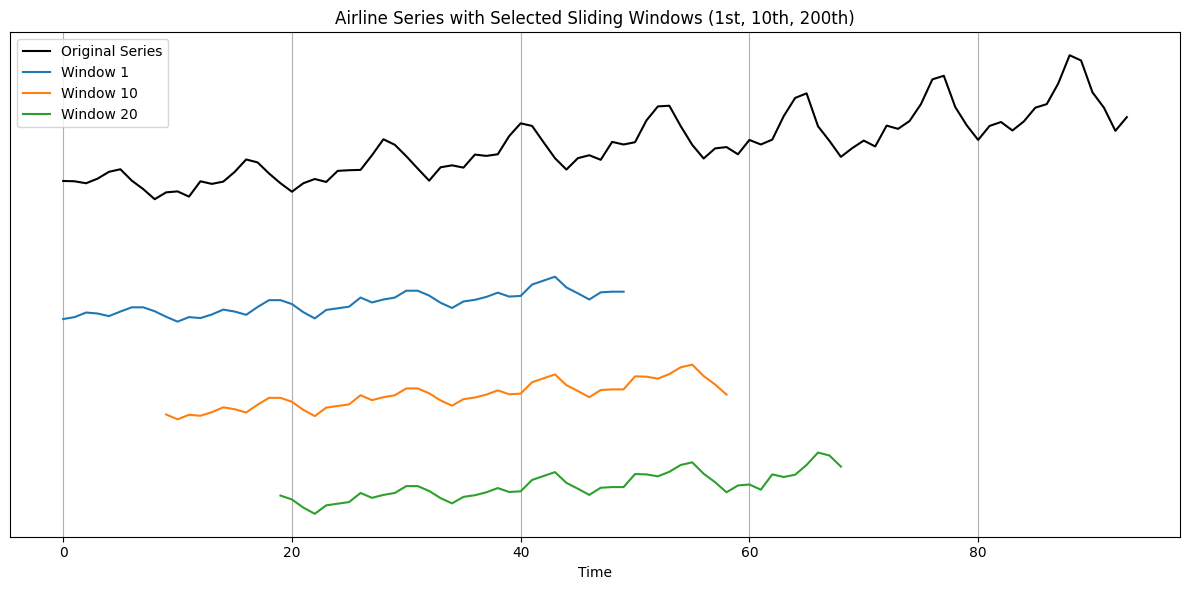

In [37]:
import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_airline

# Window all the series
window = 50
X = sliding_window_view(y, window_shape=window)
X_train = X[:-1]
X_test = X[-1:]
y_train = y = y[window:]
# plot the whole series and three windows with an offset
# Plot full series
plt.figure(figsize=(12, 6))
plt.plot(y, label="Original Series", color="black")

# Vertical offset for clarity
offset = 300  # adjust depending on your data's scale
# Indices of the windows to plot
window_indices = [0, 9, 19]
# Plot selected windowed series
for idx, i in enumerate(window_indices):
    start = i
    end = i + 50
    plt.plot(
        np.arange(start, end), X_train[i] - offset * (idx + 1), label=f"Window {i+1}"
    )

# Remove y-axis
plt.gca().axes.get_yaxis().set_visible(False)

plt.legend()
plt.title("Airline Series with Selected Sliding Windows (1st, 10th, 200th)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(94, 50)
(94,)
(1, 50)


We can now build a regression model and make a prediction. This can be 
a generic `sklearn` such as `LinearRegression` or `RandomForestRegressor` or any of 
the large number of time series specific regressors in `aeon` such as `DrCIFRegressor`

In [39]:
from sklearn.linear_model import LinearRegression

from aeon.regression.interval_based import DrCIFRegressor

lr = LinearRegression()
dr = DrCIFRegressor(n_estimators=10)
lr.fit(X_train, y_train)
dr.fit(X_train, y_train)
p1 = lr.predict(X_test)
p2 = dr.predict(X_test)
print(f"LR predicts {p1} DrCIF predicts {p2}")

LR predicts [463.60934602] DrCIF predicts [425.5]


All of this goes on inside `RegressionForecaster`, which defaults to using 
`LinearRegression` with a forecasting horizon of 1. You have to pass the window 
length to use to the constructor. 

In [40]:
from aeon.datasets import load_airline
from aeon.forecasting import RegressionForecaster

airline = load_airline()
rf = RegressionForecaster(window=50)
rf.fit(airline)
p3 = rf.predict(airline)
print(f" Forecast for airline with linear regression = {p1} and {p3}")
rf2 = RegressionForecaster(regressor=DrCIFRegressor(n_estimators=10), window=50)
rf2.fit(airline)
p4 = rf.predict(airline)
print(f" Forecast for airline with DrCIF = {p1} and {p3}")

 Forecast for airline with linear regression = [463.60934602] and 463.6093460189972
 Forecast for airline with DrCIF = [463.60934602] and 463.6093460189972


You can see all the available regressors in aeon like this. They are all documented 
in the API and have examples 

In [41]:
from aeon.utils.discovery import all_estimators

all_estimators("regressor")

[('CanonicalIntervalForestRegressor',
  aeon.regression.interval_based._cif.CanonicalIntervalForestRegressor),
 ('Catch22Regressor', aeon.regression.feature_based._catch22.Catch22Regressor),
 ('DisjointCNNRegressor',
  aeon.regression.deep_learning._disjoint_cnn.DisjointCNNRegressor),
 ('DrCIFRegressor', aeon.regression.interval_based._drcif.DrCIFRegressor),
 ('DummyRegressor', aeon.regression._dummy.DummyRegressor),
 ('EncoderRegressor', aeon.regression.deep_learning._encoder.EncoderRegressor),
 ('FCNRegressor', aeon.regression.deep_learning._fcn.FCNRegressor),
 ('FreshPRINCERegressor',
  aeon.regression.feature_based._fresh_prince.FreshPRINCERegressor),
 ('HydraRegressor', aeon.regression.convolution_based._hydra.HydraRegressor),
 ('InceptionTimeRegressor',
  aeon.regression.deep_learning._inception_time.InceptionTimeRegressor),
 ('IndividualInceptionRegressor',
  aeon.regression.deep_learning._inception_time.IndividualInceptionRegressor),
 ('IndividualLITERegressor',
  aeon.regressi

All aeon forecasters predict a single value. If you want to forecast a range of 
values ahead you should use the functions `recursive_foreacast` or `direct_forecast` 
(notebooks coming soon). 